# **Classify covid-19 from x-ray images**

# **Import Libs**

In [4]:
#common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

#sklearn
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras import Input 
from tensorflow.keras.layers import Conv2D, Activation, Add, Dense, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [5]:
import os
os.environ['KAGGLE_USERNAME']= "rizkapratama" # Kaggle Username 
os.environ['KAGGLE_KEY'] = "504b6715591ce1c43520743884b1122a" # Kaggle Key 
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset # api dataset

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile

local_zip = '/content/coronahack-chest-xraydataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **Exploring Data**

In [7]:
metadata = pd.read_csv('/content/Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('/content/Chest_xray_Corona_dataset_Summary.csv')

In [8]:
metadata.sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5369,5392,IM-0030-0001.jpeg,Normal,TEST,NaN,NaN
1683,1683,person1249_virus_2118.jpeg,Pnemonia,TRAIN,NaN,Virus
664,664,NORMAL2-IM-0464-0001.jpeg,Normal,TRAIN,NaN,NaN
3203,3203,person311_bacteria_1452.jpeg,Pnemonia,TRAIN,NaN,bacteria
5709,5732,person100_bacteria_480.jpeg,Pnemonia,TEST,NaN,bacteria


In [9]:
train_df = metadata[metadata.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata[metadata.Dataset_type == 'TEST'].reset_index(drop=True)
assert train_df.shape[0] + test_df.shape[0] == metadata.shape[0]
print(f'Train df shape: {train_df.shape}')
print(f'Test df shape: {test_df.shape}')

Train df shape: (5286, 6)
Test df shape: (624, 6)


In [10]:
#missing values
print(f'Count of null values in train:\n{train_df.isnull().sum()}')
print(f'Count of null values in test:\n{test_df.isnull().sum()}')

Count of null values in train:
Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64
Count of null values in test:
Unnamed: 0                  0
X_ray_image_name            0
Label                       0
Dataset_type                0
Label_2_Virus_category    624
Label_1_Virus_category    234
dtype: int64


In [11]:
#fill null value by unknow
train_df = train_df.fillna('unknown')
test_df = test_df.fillna('unknown')

In [12]:
train_df.sample(6)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4846,4846,person819_bacteria_2730.jpeg,Pnemonia,TRAIN,unknown,bacteria
4213,4213,person588_virus_1135.jpeg,Pnemonia,TRAIN,unknown,Virus
3703,3703,person442_virus_899.jpeg,Pnemonia,TRAIN,unknown,Virus
2595,2595,person1537_bacteria_4020.jpeg,Pnemonia,TRAIN,unknown,bacteria
2061,2061,person1282_bacteria_3245.jpeg,Pnemonia,TRAIN,unknown,bacteria
2748,2748,person1679_bacteria_4448.jpeg,Pnemonia,TRAIN,unknown,bacteria


In [13]:
test_df.sample(4)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
288,5597,person146_bacteria_704.jpeg,Pnemonia,TEST,unknown,bacteria
163,5472,NORMAL2-IM-0207-0001.jpeg,Normal,TEST,unknown,unknown
575,5884,person172_bacteria_828.jpeg,Pnemonia,TEST,unknown,bacteria
293,5602,person143_bacteria_689.jpeg,Pnemonia,TEST,unknown,bacteria


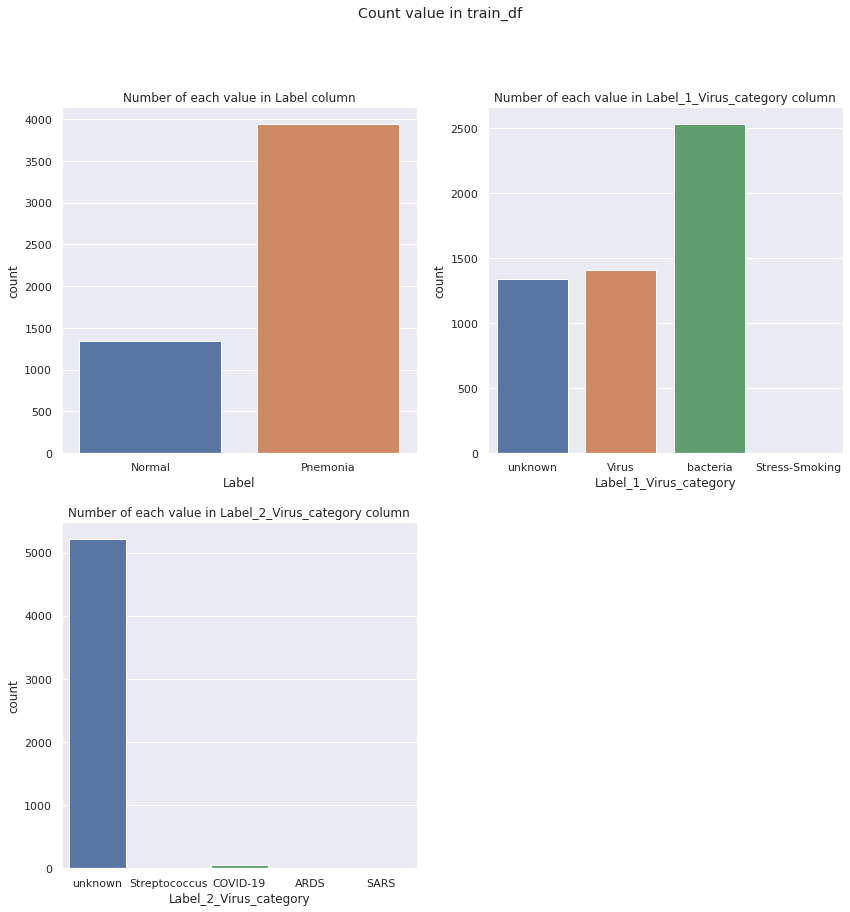

In [14]:
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

sns.set_theme(style='darkgrid')
fig = plt.figure(figsize=(14,14))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x=col[i], data=train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
fig.suptitle('Count value in train_df')
plt.show()

In [15]:
pnemonia_df = train_df[train_df.Label == 'Pnemonia']
print(f'Number of pnemonia in training dataset: { len(pnemonia_df) }')

Number of pnemonia in training dataset: 3944


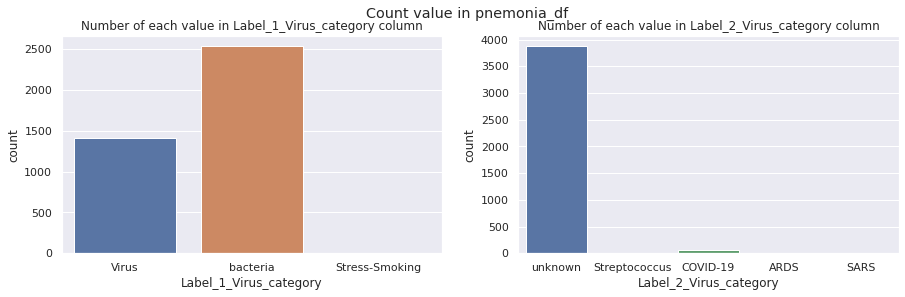

In [16]:
fig = plt.figure(figsize=(15,4))
for i in range(2):
  ax = plt.subplot(1, 2, i+1)
  ax = sns.countplot(x=col[i+1], data=pnemonia_df)
  ax.set_title(f'Number of each value in {col[i + 1]} column')
fig.suptitle('Count value in pnemonia_df')
plt.show()

In [17]:
pnemonia_label2 = pnemonia_df[pnemonia_df.Label_2_Virus_category != 'unknown']
print(f'Pnemonia without unknown value in Label_2_Virus_category : {len(pnemonia_label2)} ')

Pnemonia without unknown value in Label_2_Virus_category : 69 


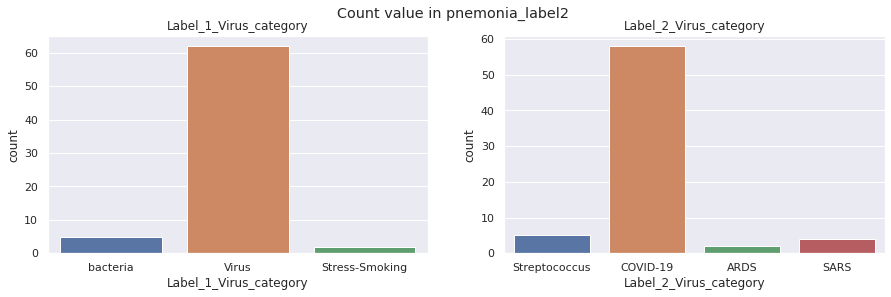

In [18]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=col[i+1], data=pnemonia_label2)
    ax.set_title(col[i+1])
fig.suptitle('Count value in pnemonia_label2')
plt.show()

# **Prepare Data**

In [19]:
path  = ('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset')
train_folder = os.path.join(path, 'train')
test_folder = os.path.join(path, 'test')

assert os.path.isdir(train_folder)
assert os.path.isdir(test_folder)

In [20]:
# add column image path to dataframe
train_img_path = pd.Series([os.path.join(train_folder, img_name) for img_name in train_df.X_ray_image_name], name='Image_path')
train_df = pd.concat([train_df, train_img_path], axis=1)

test_img_path = pd.Series([os.path.join(test_folder, img_name) for img_name in test_df.X_ray_image_name], name='Image_path')
test_df = pd.concat([test_df, test_img_path], axis=1)

print(f'Shape of train_df after add column: { train_df.shape }')
print(f'Shape of test_df after add column: { test_df.shape }')

Shape of train_df after add column: (5286, 7)
Shape of test_df after add column: (624, 7)


In [21]:
normal_train_df = train_df[train_df.Label == 'Normal']
assert len(normal_train_df) == normal_train_df.Label_1_Virus_category.value_counts().unknown
assert len(normal_train_df) == normal_train_df.Label_2_Virus_category.value_counts().unknown
print(f'Shape of normal_train_df: { normal_train_df.shape }')

covid19_train_df = train_df[(train_df.Label == 'Pnemonia') & (train_df.Label_2_Virus_category == 'COVID-19')]
print(f'Shape of covid19_train_df: { covid19_train_df.shape }')

normal_test_df = test_df[test_df.Label == 'Normal']
assert len(normal_test_df) == normal_test_df.Label_1_Virus_category.value_counts().unknown
assert len(normal_test_df) == normal_test_df.Label_2_Virus_category.value_counts().unknown
print(f'Shape of normal_test_df: { normal_test_df.shape }')

covid19_test_df = test_df[(test_df.Label == 'Pnemonia') & (test_df.Label_2_Virus_category == 'COVID19')]
print(f'Shape of test_df: {len(covid19_test_df)}')

Shape of normal_train_df: (1342, 7)
Shape of covid19_train_df: (58, 7)
Shape of normal_test_df: (234, 7)
Shape of test_df: 0


In [22]:
test_df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Image_path
0,5309,IM-0021-0001.jpeg,Normal,TEST,unknown,unknown,/content/Coronahack-Chest-XRay-Dataset/Coronah...
1,5310,IM-0019-0001.jpeg,Normal,TEST,unknown,unknown,/content/Coronahack-Chest-XRay-Dataset/Coronah...
2,5311,IM-0017-0001.jpeg,Normal,TEST,unknown,unknown,/content/Coronahack-Chest-XRay-Dataset/Coronah...
3,5312,IM-0016-0001.jpeg,Normal,TEST,unknown,unknown,/content/Coronahack-Chest-XRay-Dataset/Coronah...
4,5313,IM-0015-0001.jpeg,Normal,TEST,unknown,unknown,/content/Coronahack-Chest-XRay-Dataset/Coronah...
...,...,...,...,...,...,...,...
619,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,unknown,Virus,/content/Coronahack-Chest-XRay-Dataset/Coronah...
620,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,unknown,Virus,/content/Coronahack-Chest-XRay-Dataset/Coronah...
621,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,unknown,Virus,/content/Coronahack-Chest-XRay-Dataset/Coronah...
622,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,unknown,Virus,/content/Coronahack-Chest-XRay-Dataset/Coronah...


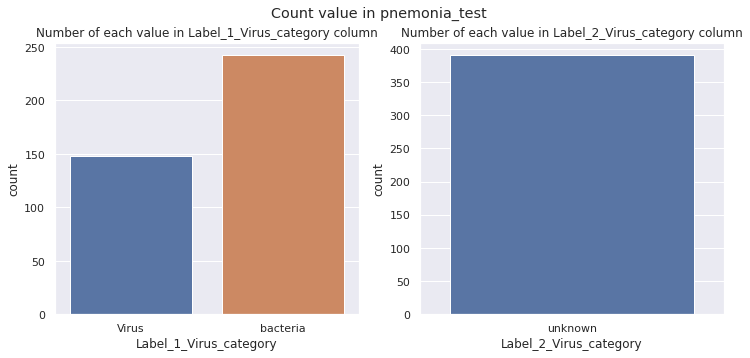

In [23]:
pnemonia_test = test_df[test_df.Label == 'Pnemonia']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=col[i + 1], data=pnemonia_test)
    ax.set_title(f'Number of each value in { col[i + 1] } column')
plt.suptitle('Count value in pnemonia_test')
plt.show()

Karena pada test_df tidak mempunyai data covid_19 untuk dataset, maka dilakukan pengambilan data dari train_df.

In [24]:
split = covid19_train_df
covid19_train_df = split[:48]
covid19_test_df = split[38:]

print(f'covid19_train_df aftter split: {covid19_train_df.shape}')
print(f'covid19_test_df after split: {covid19_test_df.shape}')

covid19_train_df aftter split: (48, 7)
covid19_test_df after split: (20, 7)


In [25]:
print(f'Shape of normal_train.df: {normal_train_df.shape}')
print(f'Shape of covid19_train.df: {covid19_train_df.shape}')
print(f'Shape of normal_test.df: {normal_test_df.shape}')
print(f'Shape of covid19_test.df: {covid19_test_df.shape}')

Shape of normal_train.df: (1342, 7)
Shape of covid19_train.df: (48, 7)
Shape of normal_test.df: (234, 7)
Shape of covid19_test.df: (20, 7)


In [26]:
# normal & covid19 df to train & test dataset
train_df = pd.concat([normal_train_df, covid19_train_df], axis=0).loc[:, ['Image_path', 'Label']]
test_df = pd.concat([normal_test_df, covid19_test_df], axis=0).loc[:, ['Image_path', 'Label']]

#change to 'negative' & 'positive' label
train_df.Label = train_df.Label.map(lambda label: 'Negative' if label == 'Normal' else 'Positive')
test_df.Label = test_df.Label.map(lambda label: 'Negative' if label == 'Normal' else 'Positive')

#shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [27]:
#Split validation dataset, 80:20
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)
print(f'training dataset: {len(train_df)}')
print(f'validation dataset: {len(val_df)}')
print(f'test dataset: {len(test_df)}')

training dataset: 1112
validation dataset: 278
test dataset: 254


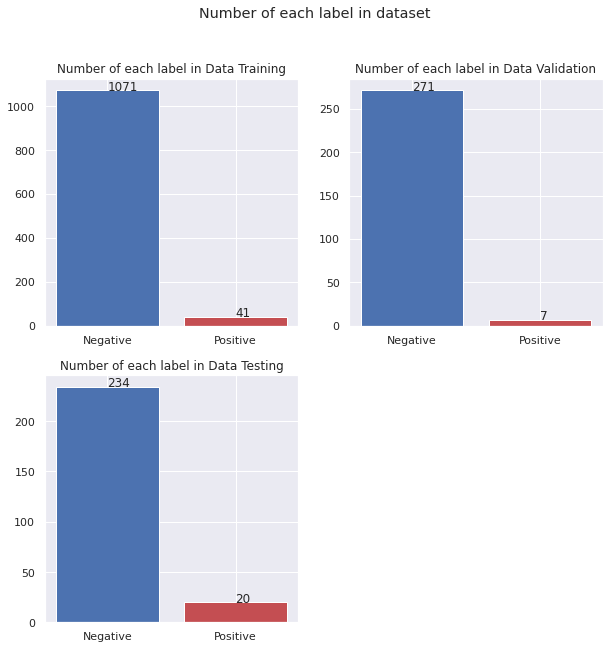

In [28]:
datasets = [train_df, val_df, test_df]
titles = ['Data Training', 'Data Validation', 'Data Testing']
label = ['Negative', 'Positive']

fig = plt.figure(figsize=(10, 10))
for i in range(3):    
    dataset = datasets[i]
    label_count = dataset.Label.value_counts()
    count = [label_count[0], label_count[1]]
    ax = plt.subplot(2, 2, i+1)
    ax.bar(label, count, color=['b', 'r'])
    ax.set_title('Number of each label in '+ titles[i])
    for index, value in enumerate(count):
        plt.text(index, value, value)
plt.suptitle('Number of each label in dataset')
plt.show()

# **Visualize Images**

In [29]:
test_df.head()

,Image_path,Label
0,/content/Coronahack-Chest-XRay-Dataset/Coronah...,Negative
1,/content/Coronahack-Chest-XRay-Dataset/Coronah...,Negative
2,/content/Coronahack-Chest-XRay-Dataset/Coronah...,Negative
3,/content/Coronahack-Chest-XRay-Dataset/Coronah...,Negative
4,/content/Coronahack-Chest-XRay-Dataset/Coronah...,Negative


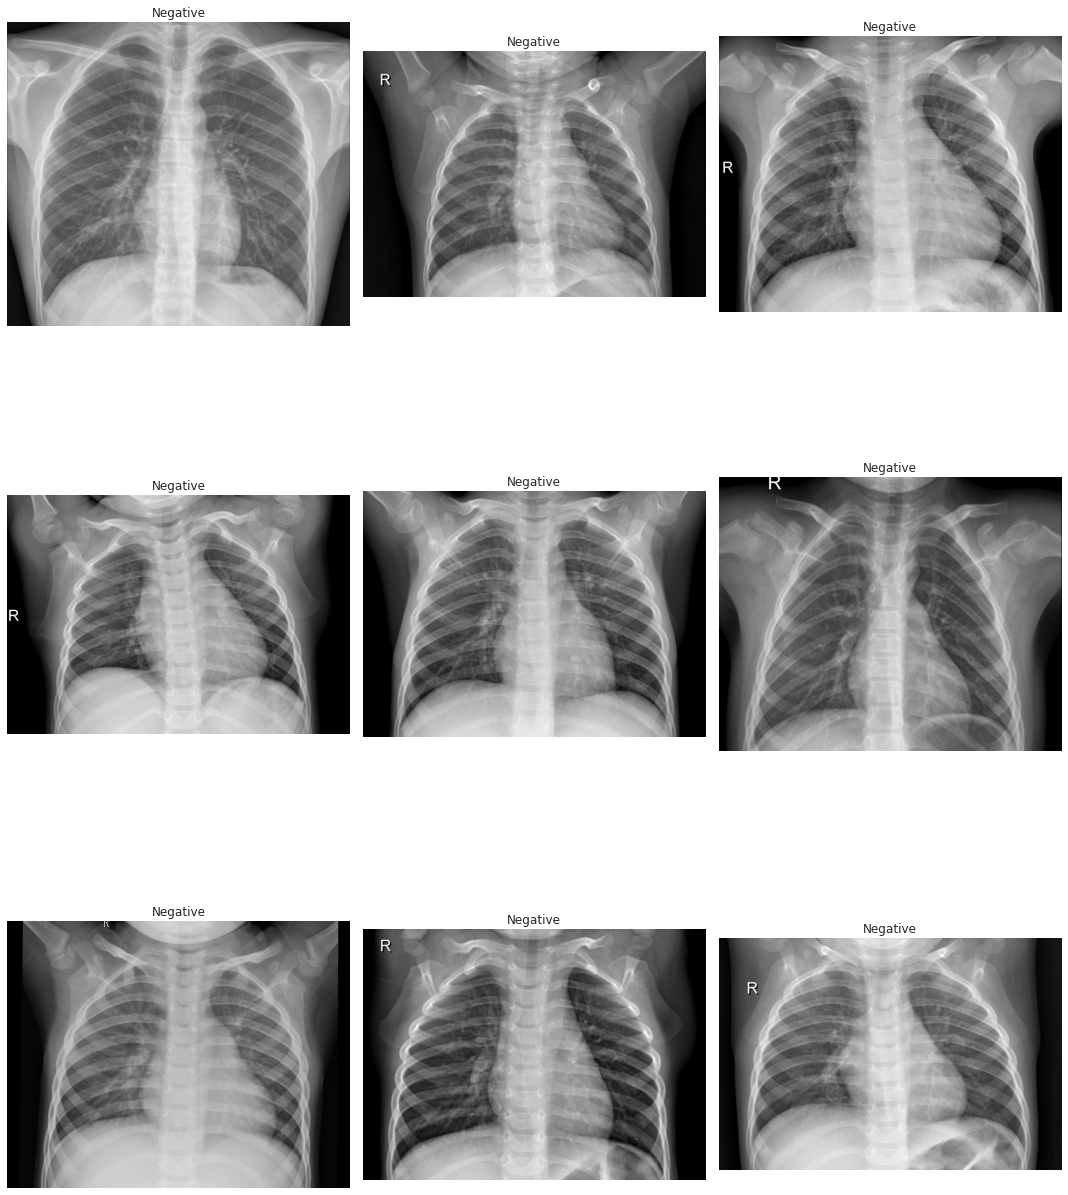

In [30]:
fig = plt.figure(figsize=(15,20))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  img_path = test_df.Image_path[i]
  label = test_df.Label[i]
  img = load_img(img_path)
  ax.axis('off')
  ax.set_title(label)
  ax.imshow(img)

plt.tight_layout()

# **Image Augmentation**

In [31]:
train_path = ImageDataGenerator().flow_from_dataframe(dataframe=train_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(230, 230),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=True)

val_path = ImageDataGenerator().flow_from_dataframe(dataframe=val_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(230, 230),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=True)

test_path = ImageDataGenerator().flow_from_dataframe(dataframe=test_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(230, 230),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=False)

Found 1112 validated image filenames belonging to 2 classes.
Found 278 validated image filenames belonging to 2 classes.
Found 254 validated image filenames belonging to 2 classes.


# **Build Model**

In [32]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
    
        tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')

])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(0.1),
                             patience=5,
                             min_lr=1e-7,
                             min_delta = 1e-4,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              mode = 'max',
                              patience=10,
                              min_delta=0,
                              verbose=1,
                              restore_best_weights=True)


callbacks = [reduce_lr, early_stopping]

In [34]:
model.compile(
    loss='binary_crossentropy', 
    optimizer= 'adam',
    metrics= ['accuracy']
)

history = model.fit(
    train_path,
    epochs = 100,
    batch_size = 128,
    verbose=1,
    validation_data = val_path,
    callbacks=callbacks
)

Epoch 1/100
9/9 [==============================] - 219s 24s/step - loss: 25.4113 - accuracy: 0.8085 - val_loss: 0.1399 - val_accuracy: 0.9748
Epoch 2/100
9/9 [==============================] - 210s 23s/step - loss: 0.1439 - accuracy: 0.9631 - val_loss: 0.0800 - val_accuracy: 0.9748
Epoch 3/100
9/9 [==============================] - 209s 24s/step - loss: 0.0990 - accuracy: 0.9640 - val_loss: 0.0486 - val_accuracy: 0.9856
Epoch 4/100
9/9 [==============================] - 209s 23s/step - loss: 0.1123 - accuracy: 0.9568 - val_loss: 0.0642 - val_accuracy: 0.9748
Epoch 5/100
9/9 [==============================] - 209s 23s/step - loss: 0.0691 - accuracy: 0.9631 - val_loss: 0.0364 - val_accuracy: 0.9748
Epoch 6/100
9/9 [==============================] - 210s 24s/step - loss: 0.0449 - accuracy: 0.9631 - val_loss: 0.0333 - val_accuracy: 0.9748
Epoch 7/100
9/9 [==============================] - 209s 24s/step - loss: 0.0431 - accuracy: 0.9631 - val_loss: 0.0323 - val_accuracy: 0.9748
Epoch 8/100



# **Plot loss and Accuracy**

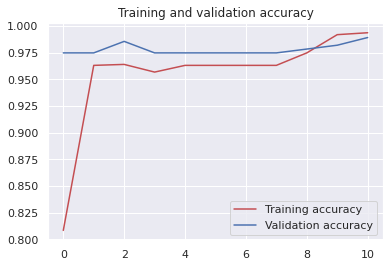

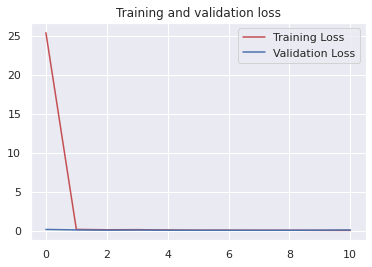

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Model TF-Lite**

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpx4tm7o8r/assets


In [37]:

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)